## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import glob
import matplotlib as plt
from collections import OrderedDict
import random

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os
from sklearn.model_selection import train_test_split


from Utils import *

## Subject 1 Data and Events Loading 

In [2]:
loaded_data,load_labels = load_data(subject_count=8)

Subject 8: 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


In [3]:
num_subj = 8
processed_labels = process_load_labels(load_labels,num_subj)

In [4]:
beg_end = []
for data in processed_labels:
    val = start_end_data_finder(data)
    beg_end.append(val)

In [5]:
start_end_data = process_start_end(start_end = beg_end, threshold=20)


In [6]:
all_extracted_data = []
for i in range(len(start_end_data)):
    extracted_data = data_extractor(start_end_data[i],loaded_data[i])
    all_extracted_data.append(extracted_data)

In [62]:
class_data = {}
combined_dict = {}
for class_idx in range(6):
    class_data[class_idx] = []

for id, sublist in enumerate(all_extracted_data):
    for idx, secondary_list in enumerate(sublist):
        class_data[idx].append(len(secondary_list))

for class_idx, lengths in class_data.items():
    total_length = sum(lengths)
    combined_dict[f"{class_idx}"] = total_length
    print(f"Class {class_idx}: Data points = {total_length}")


Class 0: Data points = 2080
Class 1: Data points = 1845
Class 2: Data points = 1174
Class 3: Data points = 2067
Class 4: Data points = 1831
Class 5: Data points = 1831


In [63]:
# Initialize a list to store combined data for each class
combined_data = [[] for _ in range(6)]  # Assuming you have 6 classes

# Iterate through subjects and classes
for i in range(8):  # 6 subjects
    for j in range(6):  # 6 classes
        # Extend the data for the current class to the combined_data
        combined_data[j].extend(all_extracted_data[i][j])

# Now, combined_data contains 6 lists, each for classes of all subjects combined


In [64]:
min_length = min(combined_dict.values(), key=lambda x: int(x))
min_length


1174

In [65]:
threshold = 20
no_events_data_extracted = []
for idx, subj_data in enumerate(loaded_data):
    no_event = data_extractor_noevent(subj_data, load_labels[idx], min_length,threshold = threshold)
    no_events_data_extracted.append(no_event)


In [66]:
class_labels = np.ones(min_length*6)

for i in range(6):
    class_labels[i*min_length:(i+1)*min_length] = class_labels[i*min_length:(i+1)*min_length] *(i)

noevent_label = np.ones(min_length)*(6)

all_class_labels = np.concatenate((class_labels,noevent_label))

In [67]:


# Initialize combined_data as a list of lists (for demonstration purposes)

# Shuffle and concatenate data from combined_data
selected_data = []
for class_data in combined_data:
    # Append the first `min_length` data points to the selected_data list
    selected_data.extend(class_data[:min_length])

# Shuffle and concatenate data from no_events_data_extracted
for arr in no_events_data_extracted:
    # Check if the current array has enough data to select min_length/6 points
    if len(arr) >= min_length // 6:
        # Shuffle the data points within the array (optional)
        random.shuffle(arr)
    
        # Append the first `min_length/6` data points to the selected_data list
        selected_data.extend(arr[:min_length // 8])


In [68]:
selected_data = np.array(selected_data)
selected_data = np.reshape(np.array(selected_data),(selected_data.shape[0],selected_data.shape[1]*selected_data.shape[2]))
all_class_labels = all_class_labels[:-6]

In [69]:
print("selected_data shape:", selected_data.shape)
print("labels shape:", all_class_labels.shape)
print("selected_data data type:", selected_data.dtype)
print("labels data type:", all_class_labels.dtype)

selected_data shape: (8212, 672)
labels shape: (8212,)
selected_data data type: int64
labels data type: float64


In [70]:

augmented_data = []

for signal in selected_data:
    flat_signal = signal.flatten()
    
    augmented_signal = apply_data_augmentation(flat_signal).astype('int64')
    augmented_data.append(augmented_signal)

augmented_data_array = np.array(augmented_data)



In [72]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder



# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Reshape the class_labels into a 2D array
all_class_labels = np.array(all_class_labels).reshape(-1, 1)

# Fit and transform the encoder on the class labels
one_hot_labels = encoder.fit_transform(all_class_labels)

# Print the one-hot encoded labels
print(one_hot_labels)


[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


C:\Users\amoha\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [44]:

from sklearn.preprocessing import StandardScaler
all_data_shuffled , all_labels_shuffled = shuffle(augmented_data_array, one_hot_labels, random_state = 0)


ss = StandardScaler()
all_data_shuffled_scaled = ss.fit_transform(all_data_shuffled)


In [79]:
all_data_shuffled = all_data_shuffled[:, :, np.newaxis]

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming you have reshaped your selected_data

n_channels = all_data_shuffled.shape[1]
n_timepoints = all_data_shuffled.shape[2]



model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(n_channels, n_timepoints)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

X_train, X_test, y_train, y_test = train_test_split(selected_data, one_hot_labels, test_size=0.3, random_state=42)
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 670, 64)           256       
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 335, 64)           0         
 g1D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 21440)             0         
                                                                 
 dense_23 (Dense)            (None, 64)                1372224   
                                                                 
 flatten_14 (Flatten)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                     

KeyboardInterrupt: 

In [47]:
from tensorflow.keras.models import Model

# Assuming 'model' is your trained CNN model
feature_extraction_model = Model(inputs=model.input, outputs=model.layers[-2].output)


In [53]:
classification_model = Sequential()
classification_model.add(feature_extraction_model)
classification_model.add(Dense(7, activation='softmax'))
classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

classification_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


NameError: name 'X_features' is not defined

## Data preprocessing

In [18]:
# start_end_data = start_end_data_finder(all_labels)
# data_extracted_occurances = np.reshape(data_extractor(start_end_data,all_data),(6*260,150,32) )

# no_events_data_extracted = data_extractor_noevent(all_data, all_labels,1560)
# final_data = np.empty(1560*150*32)
# final_data = np.concatenate((data_extracted_occurances,no_events_data_extracted))
# final_data = np.reshape(final_data, (3120,150*32))

# class_labels = np.ones(1560)

# for i in range(6):
#     class_labels[i*260:(i+1)*260] = class_labels[i*260:(i+1)*260] *(i)

# noevent_label = np.ones(1560)*(6)

# all_class_labels = np.concatenate((class_labels,noevent_label))


#### Scaling and Shuffling

### Dimentionality reduction

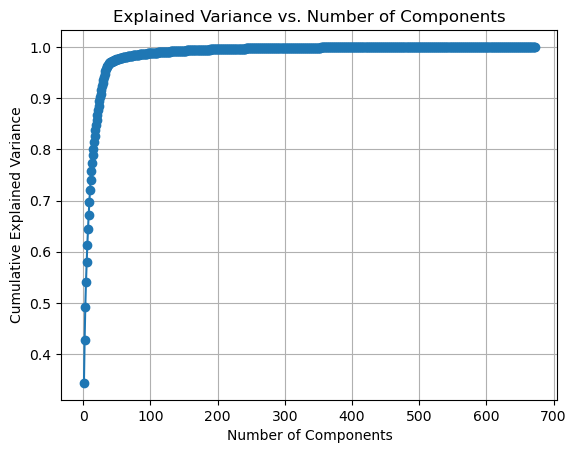

In [40]:
from sklearn.decomposition import PCA
pca = PCA()

pca.fit(all_data_shuffled_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


In [41]:
n_components = 100
pca = PCA(n_components = n_components)
pca.fit(all_data_shuffled)
pca_tr = pca.fit_transform(all_data_shuffled_scaled)

## Model Analysis

#### Support Vector machines

Accuracy: 0.32501521606816797


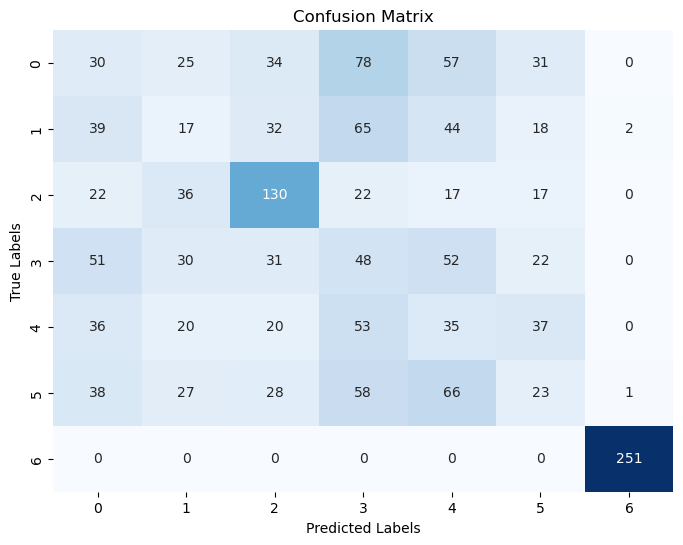

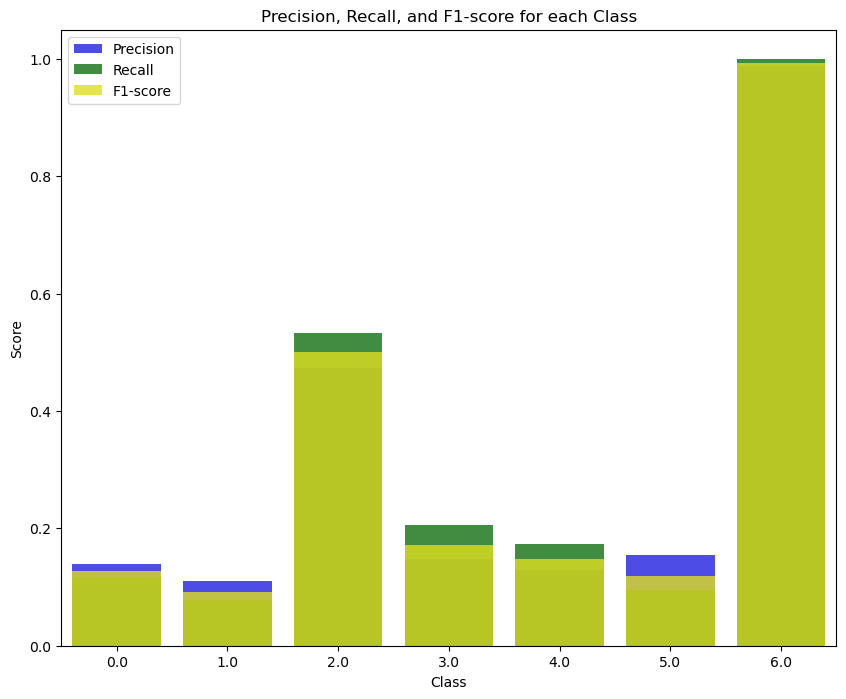

Classification Report:
              precision    recall  f1-score   support

         0.0       0.14      0.12      0.13       255
         1.0       0.11      0.08      0.09       217
         2.0       0.47      0.53      0.50       244
         3.0       0.15      0.21      0.17       234
         4.0       0.13      0.17      0.15       201
         5.0       0.16      0.10      0.12       241
         6.0       0.99      1.00      0.99       251

    accuracy                           0.33      1643
   macro avg       0.31      0.31      0.31      1643
weighted avg       0.32      0.33      0.32      1643



In [34]:
from sklearn.svm import SVC

model = SVC(kernel="rbf")
evaluate_model(model, all_data_shuffled_scaled, all_labels_shuffled)

Accuracy: 0.3256238587948874


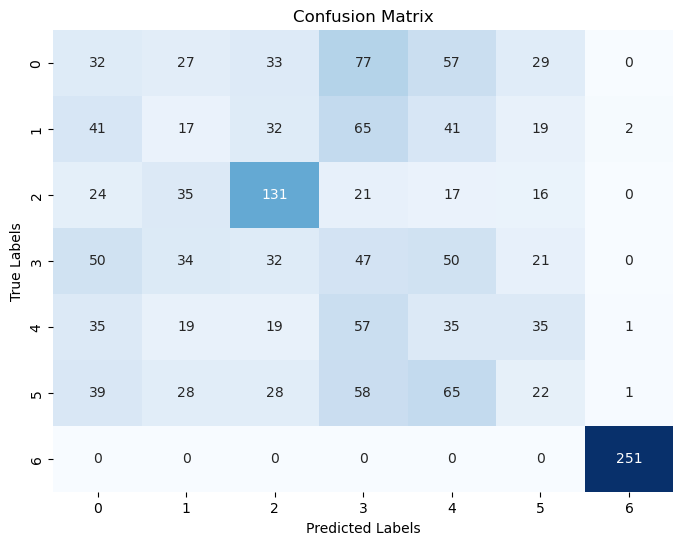

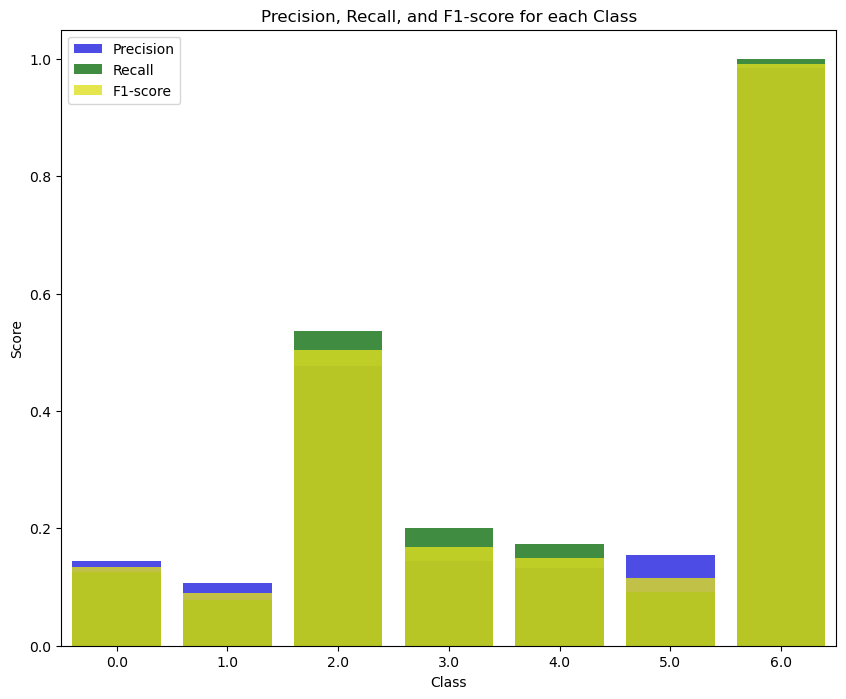

Classification Report:
              precision    recall  f1-score   support

         0.0       0.14      0.13      0.13       255
         1.0       0.11      0.08      0.09       217
         2.0       0.48      0.54      0.50       244
         3.0       0.14      0.20      0.17       234
         4.0       0.13      0.17      0.15       201
         5.0       0.15      0.09      0.11       241
         6.0       0.98      1.00      0.99       251

    accuracy                           0.33      1643
   macro avg       0.31      0.32      0.31      1643
weighted avg       0.32      0.33      0.32      1643



In [42]:
model = SVC(kernel="rbf")
evaluate_model(model, pca_tr, all_labels_shuffled)

#### Random Forest Model


Accuracy: 0.9629080118694362


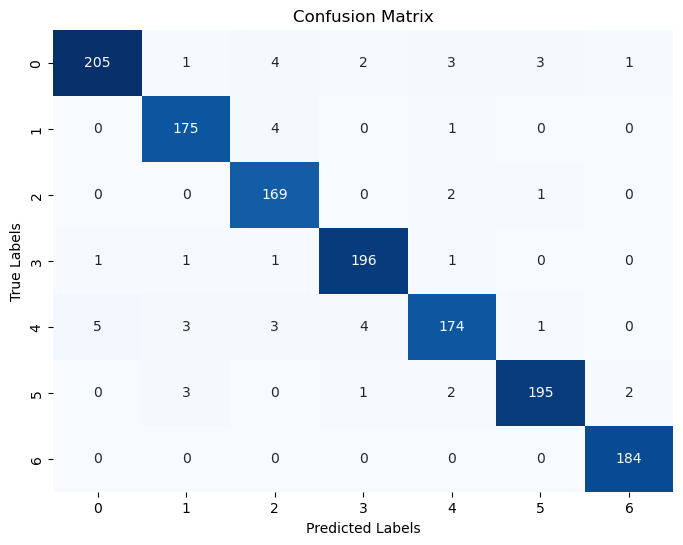

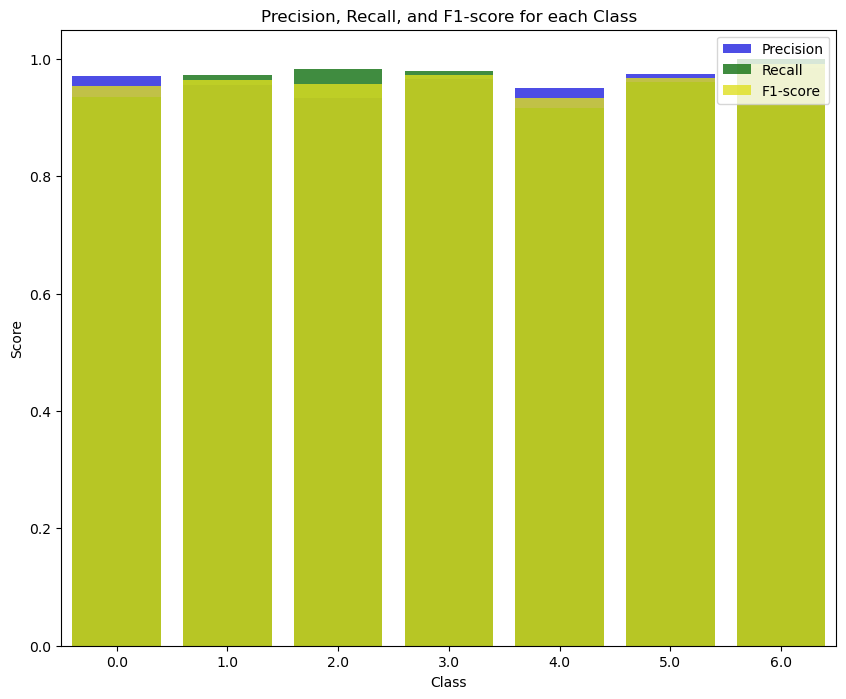

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       219
         1.0       0.96      0.97      0.96       180
         2.0       0.93      0.98      0.96       172
         3.0       0.97      0.98      0.97       200
         4.0       0.95      0.92      0.93       190
         5.0       0.97      0.96      0.97       203
         6.0       0.98      1.00      0.99       184

    accuracy                           0.96      1348
   macro avg       0.96      0.96      0.96      1348
weighted avg       0.96      0.96      0.96      1348



In [24]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500)
evaluate_model(model, pca_tr, all_labels_shuffled)

#### K nearest neighbor
**n_neighbors** : A common heuristic is to use the square root of the number of data points in the dataset as the k-value. fo this case k=√3000 ≈ 54.

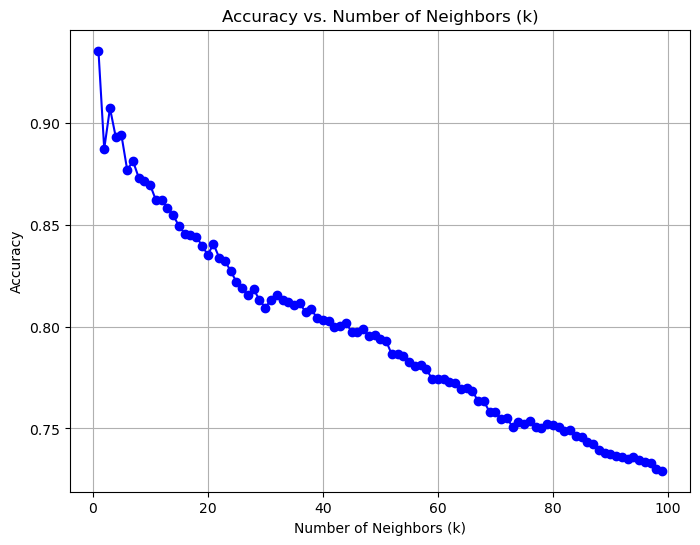

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_tr, all_labels_shuffled, test_size=0.2, random_state=42)

# Initialize lists to store accuracy scores for different k values
k_values = list(range(1, 100))
accuracy_scores = []

# Loop through different k values
for k in k_values:
    # Create and fit the k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = knn.predict(X_test)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Plot the accuracy scores for different k values
plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors (k)')
plt.grid(True)
plt.show()


Accuracy: 0.8731454005934718


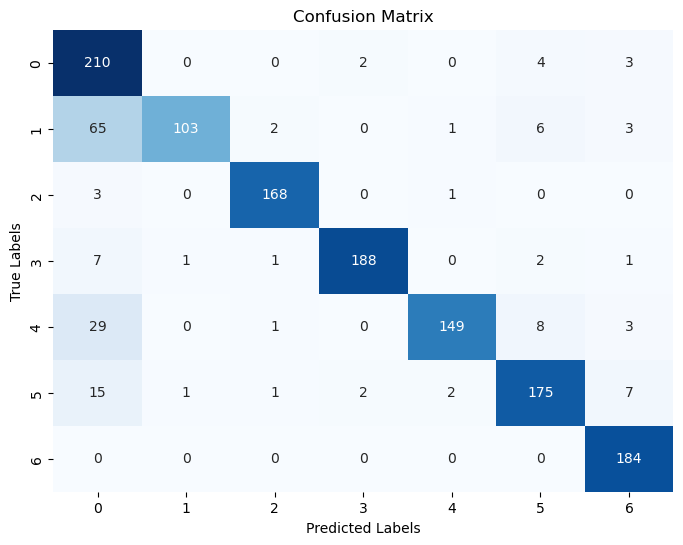

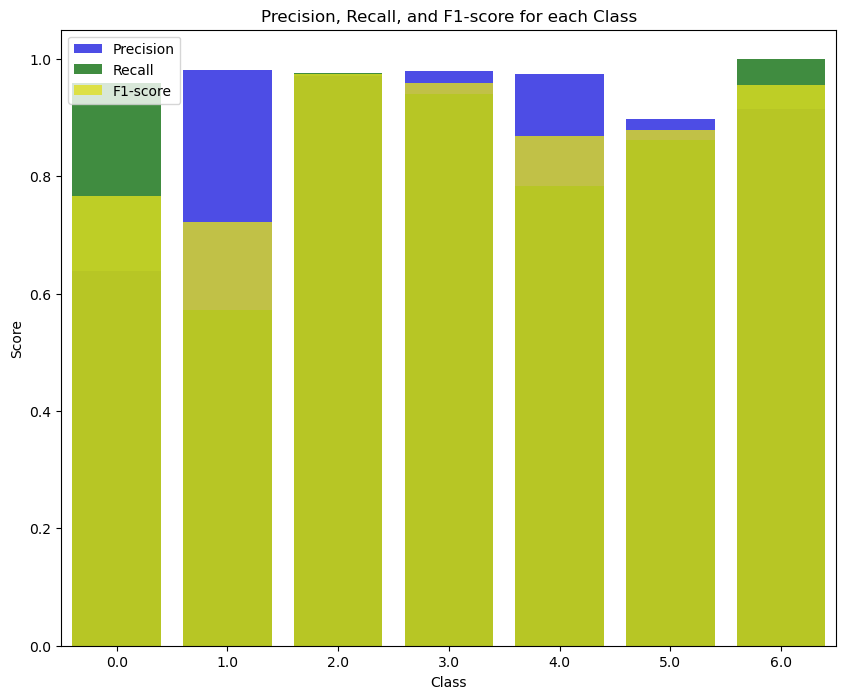

Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.96      0.77       219
         1.0       0.98      0.57      0.72       180
         2.0       0.97      0.98      0.97       172
         3.0       0.98      0.94      0.96       200
         4.0       0.97      0.78      0.87       190
         5.0       0.90      0.86      0.88       203
         6.0       0.92      1.00      0.96       184

    accuracy                           0.87      1348
   macro avg       0.91      0.87      0.88      1348
weighted avg       0.90      0.87      0.87      1348



In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

model = KNeighborsClassifier(n_neighbors = 8)
evaluate_model(model, pca_tr, all_labels_shuffled)

#### XGBoost

Accuracy: 0.9428783382789317


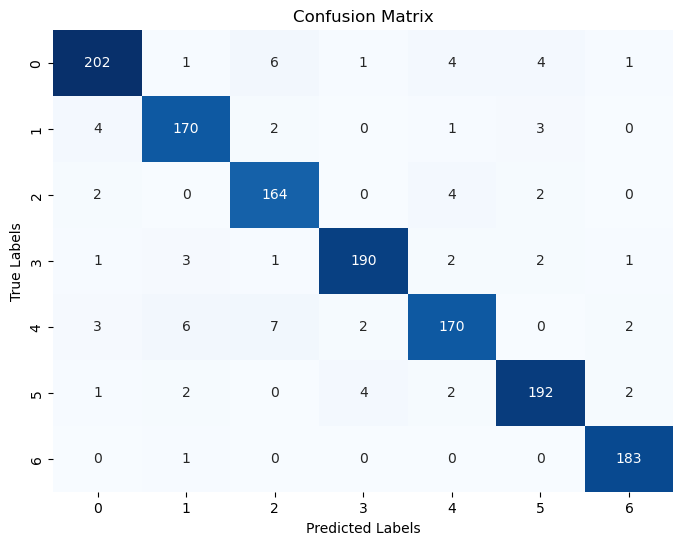

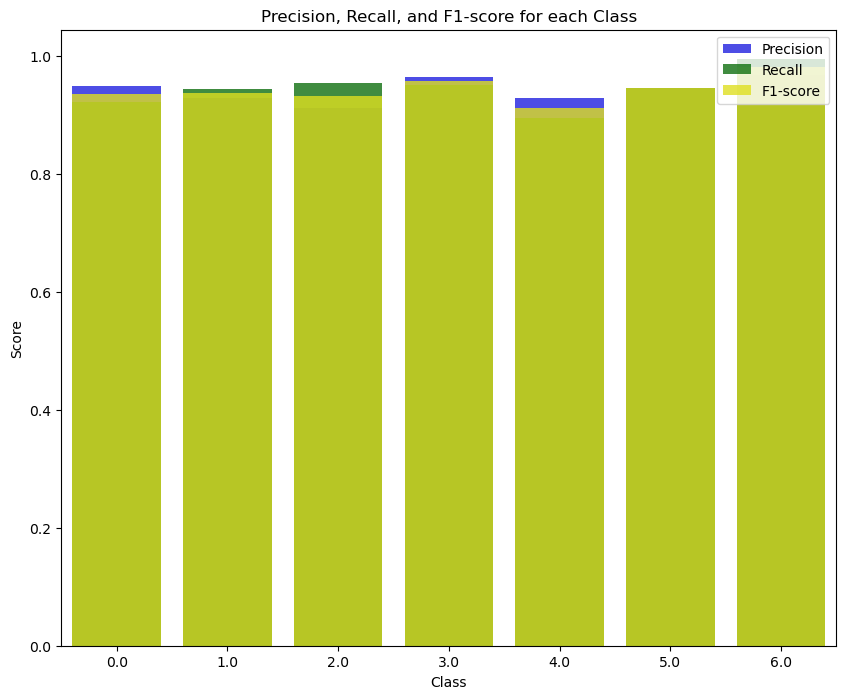

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94       219
         1.0       0.93      0.94      0.94       180
         2.0       0.91      0.95      0.93       172
         3.0       0.96      0.95      0.96       200
         4.0       0.93      0.89      0.91       190
         5.0       0.95      0.95      0.95       203
         6.0       0.97      0.99      0.98       184

    accuracy                           0.94      1348
   macro avg       0.94      0.94      0.94      1348
weighted avg       0.94      0.94      0.94      1348



In [27]:
import xgboost as xgb
params = {
    'objective': 'multi:softmax',  # Multi-class classification objective
    'num_class': 7,                # Number of classes in the multi-class problem
    'eval_metric': 'mlogloss',     # Multiclass Logarithmic Loss
    'eta': 0.1,                    # Learning rate
    'max_depth': 3,                # Maximum depth of a tree
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.8,       # Subsample ratio of columns when constructing each tree
    'seed': 42                     # Random seed for reproducibility
}

xgb_model = xgb.XGBClassifier(**params)
evaluate_model(xgb_model, pca_tr, all_labels_shuffled)

In [30]:
test_Data,test_labels = load_data(subject_count=8)

Subject 8: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


In [38]:
subj78data={}
subj78data["7"] =  test_Data[6]
subj78data["8"] = test_Data[7]
subj78label = {}
subj78label["7"] =  test_labels[6]
subj78label["8"] = test_labels[7]